Time to load the libraries and our dataset.

In [1]:
from __future__ import print_function, division
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam #
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import transform
from tensorflow.keras.layers import ReLU
import imageio


import datetime
import sys
import os
from imageio import imread
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

In [2]:
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [3]:
path2=sorted(glob('../input/flirdata/RGB/RGB' + '/*.jpg'), key=lambda name: int(name[31:-4]))
path1=sorted(glob('../input/flirdata/thermal_8_bit/thermal_8_bit' + '/*.jpeg'), key=lambda name: int(name[51:-5]))
inds=[]
con=0
for i in range(0,len(path1)):
    a=int(path2[con][31:-4])
    b=int(path1[i][51:-5])
    if a==b:
        inds.append(i)
        con=con+1
path1=np.array(path1)[inds]
p1=path1[:50]
p2=path2[:50]
path1=np.concatenate((p1,p1,p1,p1,p1))
path2=np.concatenate((p2,p2,p2,p2,p2))

In [4]:
def load_data(path1,path2,batch_size=1, is_val=False):


        
        #path2=np.array(path2)[inds]  
        #print(indices)
        indices=np.random.permutation(len(path1))
        b1 = np.array(path1)[indices[:batch_size]]
        b2 = np.array(path2)[indices[:batch_size]]
        #print(path1)
        #print(path2)
        #plt.imshow(b1[0])
        #plt.imshow(b2[0])
        img_res=(256,256)
        imgs_A = []
        imgs_B = []

        for i in range(0,len(b1)):
            i1=b1[i]
            i2=b2[i]
            img1 = imread(i1)
            img2=imread(i2)
            
            img_A, img_B = img1,img2

            # decreasing the resolution 
            img_A = transform.resize(img_A, img_res)  #Ground Truth image
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)
            if len(img_A.shape)==2:
                a=img_A
                    
                img_A = np.stack((a,)*3, axis=-1)
                
                
            #print(img_A)
            #print(imgs_A)
            imgs_A.append(img_A)
            imgs_B.append(img_B)
            #print(img_B.shape)
            
            #print(imgs_A)

        imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

This function does the same work as the above, except for the fact that is used during training to load image in batches.

In [5]:
def load_batch( path1,path2,batch_size=1, is_val=False):

        #path2=np.array(path2)[inds]            
        #print(path1)
        #print(path2)            
        p=np.random.permutation(len(path1))
        #print(len(path1),len(path2))
        path1=np.array(path1)[p]
        path2=np.array(path2)[p]  
        
        #print(len(path1))
        n_batches=int(len(path1)/batch_size)
        #n_batches=batch_size
        img_res=(256,256)
        for i in range(n_batches-1):
            batch1 = path1[i*batch_size:(i+1)*batch_size]
            batch2=path2[i*batch_size:(i+1)*batch_size]
            #print(i)
            imgs_A, imgs_B = [], []
            for j in range(0,len(batch1)):
                img1=batch1[j]
                img2=batch2[j]

                img1 = imread(img1)
                img2 = imread(img2)

                img_A, img_B = img1,img2
                
                img_A = transform.resize(img_A, img_res)#Ground truth image
                img_B = transform.resize(img_B, img_res)# input image
                
 # when training => do random flip , this is a trick to avoid overfitting 
                if not is_val and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)
                if len(img_A.shape)==2:
                    a=img_A
                    
                    img_A = np.stack((a,)*3, axis=-1)
                    

                imgs_A.append(img_A)
                imgs_B.append(img_B)


            imgs_A = np.array(imgs_A)/127.5 - 1.  #normalizing the images
            imgs_B = np.array(imgs_B)/127.5 - 1.
            yield imgs_A, imgs_B
        #print((i+1)*batch_size)
        
def imread(path):
        return imageio.imread(path).astype(np.float64)

In [6]:
def show_images( d1,d2,epoch, batch_i):
        
        r, c = 3, 3
        
        imgs_A, imgs_B = load_data(d1,d2,batch_size=r, is_val=True)
        fake_A = generator.predict(imgs_B)
        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.savefig(f'x={epoch}.png')
        plt.close()

In [7]:
def build_generator():
        """U-Net Generator"""

        def conv2d(layer_input, filters, f_size=4, bn=True):
            """Layers used during downsampling"""
            initializer = tf.random_normal_initializer(0., 0.02)
            d = Conv2D(filters, kernel_size=f_size, strides=2, kernel_initializer=initializer,padding='same')(layer_input)
            
            if bn:
                d = BatchNormalization()(d,training=True)
            d = LeakyReLU(alpha=0.2)(d)
            return d

        def deconv2d(layer_input, filters, f_size=4, dropout=False):
            """Layers used during upsampling"""
            initializer = tf.random_normal_initializer(0., 0.02)
            u= ReLU()(layer_input)
            u = tf.keras.layers.Conv2DTranspose(filters, f_size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False)(layer_input)
            #if dropout:
                #u = Dropout(0.5)(u)
            u = BatchNormalization()(u,training=True)
            #u = Concatenate()([u, skip_input]) #skip connection
            return u

        
        d0 = Input(shape=img_shape)
        initializer = tf.random_normal_initializer(0., 0.02)
        # Downsampling
        d1 = conv2d(d0, gf, bn=False)
        d2 = conv2d(d1, gf*2)
        d3 = conv2d(d2, gf*4)
        d4 = conv2d(d3, gf*8)
        d5 = conv2d(d4, gf*8)
        d6 = conv2d(d5, gf*8)
        d7 = conv2d(d6, gf*8)
        d8 = Conv2D(gf*8, kernel_size=4, strides=2, kernel_initializer=initializer,padding='same')(d7)
        d8 = LeakyReLU(alpha=0.2)(d8)
        # Upsampling
        u1 = tf.keras.layers.Conv2DTranspose(gf*8, 4, strides=2,padding='same',kernel_initializer=initializer, use_bias=False)(d8)
        u1= BatchNormalization()(u1,training=True)
        u1=Concatenate()([u1, d7])

        u2 = deconv2d(u1, gf*8)
        u2=Concatenate()([u2,d6])
        u3 = deconv2d(u2, gf*8)
        u3=Concatenate()([u3,d5])
        u4 = deconv2d(u3, gf*8)
        u4=Concatenate()([u4,d4])
        u5 = deconv2d(u4, gf*4)
        u5=Concatenate()([u5, d3])
        u6 = deconv2d(u5, gf*2)
        u6=Concatenate()([u6,d2])
        u7 = deconv2d(u6, gf)
        u7=Concatenate()([u7, d1])

        #u8 = UpSampling2D(size=2)(u6)
        u7=ReLU()(u7)
        output_img = tf.keras.layers.Conv2DTranspose(channels, kernel_size=4, strides=2, padding='same',kernel_initializer=initializer, activation='tanh')(u7)
        #print(output_img.shape)
        return Model(d0, output_img)

In [8]:
#custom loss functions
def intensity_loss(target,output):
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    rgb=np.array([ 0.299,0.587,0.114])
    rgb = rgb.reshape(1,1,1, -1)
    target=tf.reduce_sum(rgb * target, -1)
    output=tf.reduce_sum(rgb * output, -1)
    return tf.reduce_mean(tf.abs(target - output))
def mgee(targets,outputs):
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

        # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

        #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

        # square
    output_gradients = tf.math.sqrt(tf.math.add(output_gradient_x, output_gradient_y))
    target_gradients = tf.math.sqrt(tf.math.add(target_gradient_x, target_gradient_y))

        # compute mean gradient error
    shape = output_gradients.shape[1:3]
    mge = tf.math.reduce_mean(tf.abs(output_gradients- target_gradients) )

    return mge 



In [9]:
# Input shape
img_rows = 256
img_cols = 256
channels = 3
img_shape = (img_rows, img_cols, channels)


# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)

# Number of filters in the first layer of G and D
gf = 64
df = 64
dloss=[]
gloss=[]
optimizer = Adam(0.0002, 0.5)#lr=0.001, beta_1=0.9, beta_2=0.999


# Build the generator
generator = build_generator()

#gan_loss+lambda*l1_loss
generator.compile(loss=['mse'],
                              loss_weights=[1],
                              optimizer=optimizer)#change loss to binary_crossentropy


2022-07-03 04:30:55.008532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 04:30:55.205906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 04:30:55.206625: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 04:30:55.207725: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Let's start the training!

In [10]:
def train( path1,path2,k,epochs,batch_size=1, show_interval=10):

        start_time = datetime.datetime.now()


        for epoch in range(epochs):
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(path1,path2,batch_size)):

                    # Condition on B and generate a translated version
                    #print(imgs_B.shape)
                fake_A = generator.predict(imgs_B)
                    #print(fake_A.shape)

               
                #  Train Generator
                g_loss = generator.train_on_batch([imgs_B], [imgs_A])
                elapsed_time = datetime.datetime.now() - start_time

            # Plot the progress
            if epoch%1==0:
              
              print ("[Epoch %d/%d]  [G loss: %f] time: %s" % (epoch, epochs,                                                                       
                                                                        
                                                                        g_loss,
                                                                        elapsed_time))
              gloss.append(g_loss)
       
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(path1,path2,epoch, batch_i)

            

2022-07-03 04:30:59.624731: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-03 04:31:00.828404: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


[Epoch 0/10]  [G loss: 0.052010] time: 0:01:59.651769


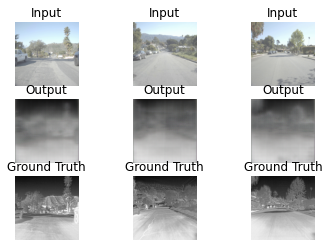

[Epoch 1/10]  [G loss: 0.043184] time: 0:03:51.218742


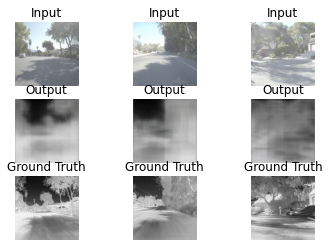

[Epoch 2/10]  [G loss: 0.033935] time: 0:05:41.753328


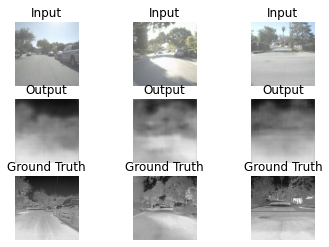

[Epoch 3/10]  [G loss: 0.034792] time: 0:07:42.790070


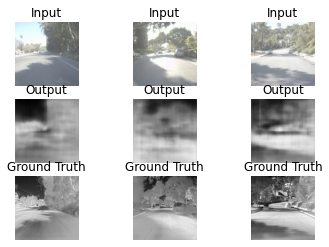

[Epoch 4/10]  [G loss: 0.034067] time: 0:09:33.166296


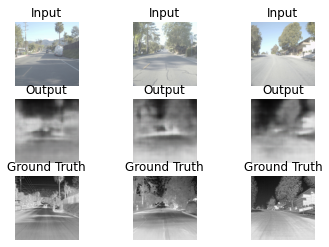

[Epoch 5/10]  [G loss: 0.021841] time: 0:11:22.362763


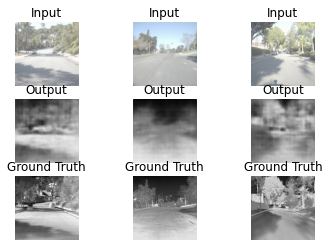

[Epoch 6/10]  [G loss: 0.027981] time: 0:13:12.058019


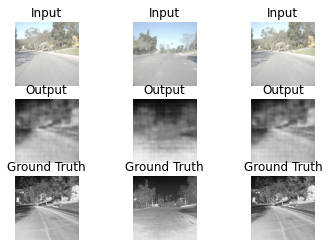

[Epoch 7/10]  [G loss: 0.019784] time: 0:15:01.240475


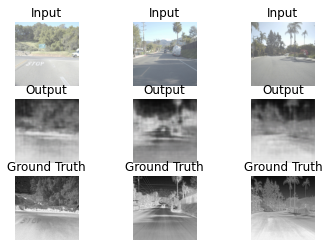

[Epoch 8/10]  [G loss: 0.017494] time: 0:16:50.963738


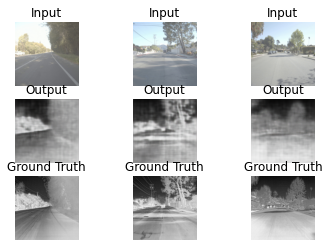

[Epoch 9/10]  [G loss: 0.017046] time: 0:18:40.958830


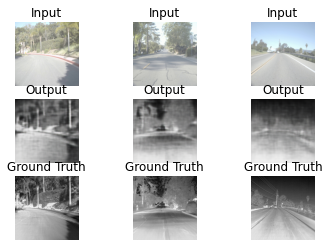

In [11]:
train(path1,path2,1,epochs=10, batch_size=4, show_interval=1)

[Epoch 0/15]  [G loss: 0.017049] time: 0:01:47.974824


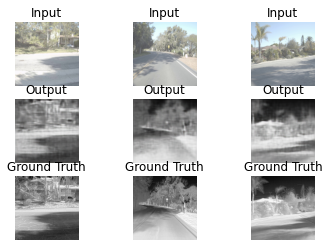

[Epoch 1/15]  [G loss: 0.012838] time: 0:03:37.395578


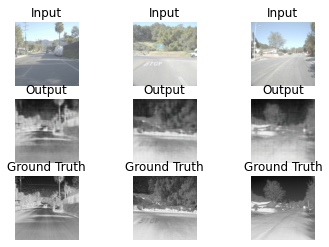

[Epoch 2/15]  [G loss: 0.013192] time: 0:05:27.607935


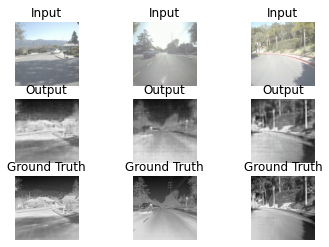

[Epoch 3/15]  [G loss: 0.011642] time: 0:07:20.438197


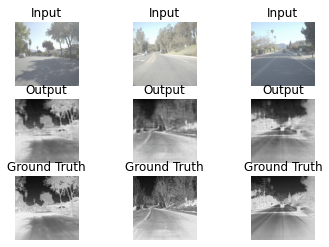

[Epoch 4/15]  [G loss: 0.010406] time: 0:09:10.144095


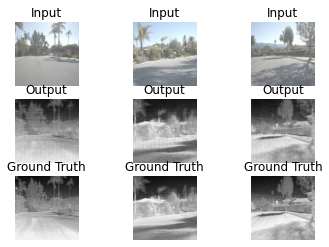

[Epoch 5/15]  [G loss: 0.010814] time: 0:10:59.951380


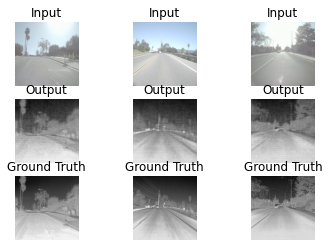

[Epoch 6/15]  [G loss: 0.012461] time: 0:12:48.349377


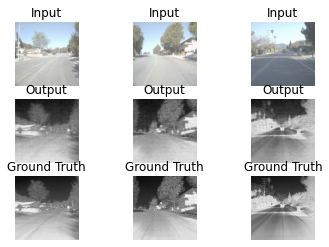

[Epoch 7/15]  [G loss: 0.009146] time: 0:14:37.693108


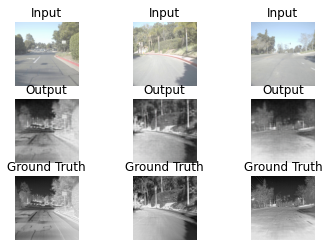

[Epoch 8/15]  [G loss: 0.008362] time: 0:16:27.544194


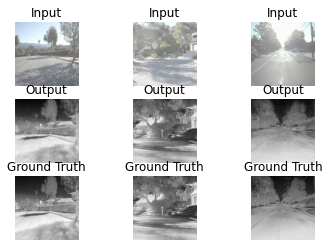

[Epoch 9/15]  [G loss: 0.007430] time: 0:18:16.548128


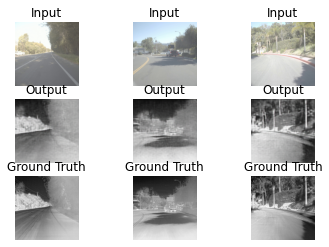

[Epoch 10/15]  [G loss: 0.008035] time: 0:20:05.340383


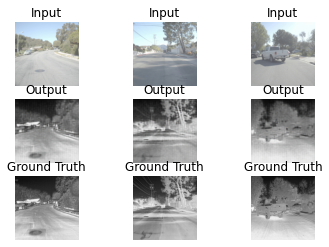

[Epoch 11/15]  [G loss: 0.013843] time: 0:21:56.161378


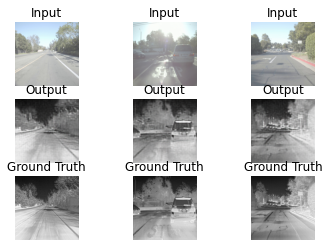

[Epoch 12/15]  [G loss: 0.008498] time: 0:23:45.496940


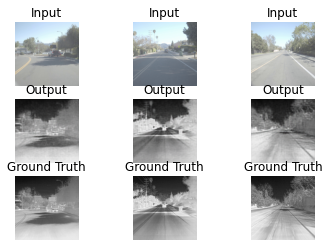

[Epoch 13/15]  [G loss: 0.009005] time: 0:25:34.413371


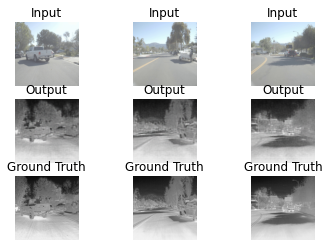

[Epoch 14/15]  [G loss: 0.007382] time: 0:27:23.875091


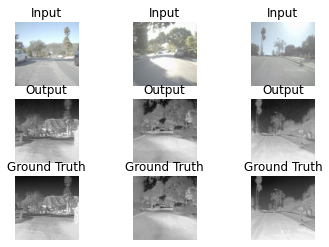

In [12]:
train(path1,path2,1,epochs=15, batch_size=4, show_interval=1)

In [17]:
path2=sorted(glob('../input/flirdata/RGB/RGB' + '/*.jpg'), key=lambda name: int(name[31:-4]))
path1=sorted(glob('../input/flirdata/thermal_8_bit/thermal_8_bit' + '/*.jpeg'), key=lambda name: int(name[51:-5]))
inds=[]
con=0
for i in range(0,len(path1)):
    a=int(path2[con][31:-4])
    b=int(path1[i][51:-5])
    if a==b:
        inds.append(i)
        con=con+1
path1=np.array(path1)[inds]
p1=path1[50:100]
p2=path2[50:100]
path1=np.concatenate((p1,p1,p1,p1,p1))
path2=np.concatenate((p2,p2,p2,p2,p2))

[Epoch 0/15]  [G loss: 0.041493] time: 0:01:49.751842


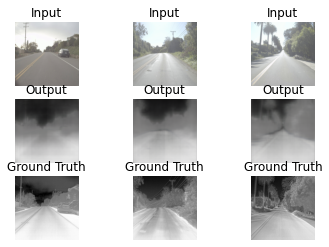

[Epoch 1/15]  [G loss: 0.055639] time: 0:03:40.475598


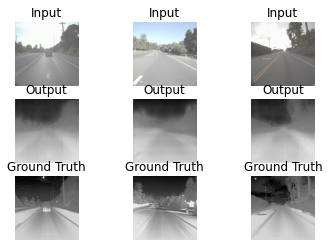

[Epoch 2/15]  [G loss: 0.050423] time: 0:05:30.807840


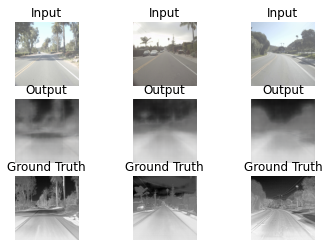

[Epoch 3/15]  [G loss: 0.033642] time: 0:07:20.933611


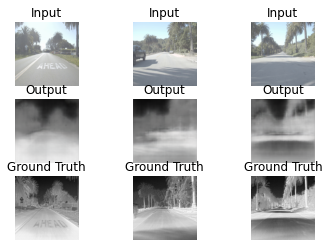

[Epoch 4/15]  [G loss: 0.040714] time: 0:09:11.585431


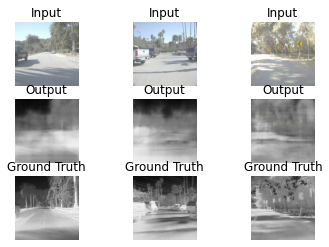

[Epoch 5/15]  [G loss: 0.019370] time: 0:11:01.778819


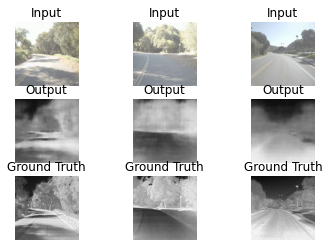

[Epoch 6/15]  [G loss: 0.030410] time: 0:12:51.238469


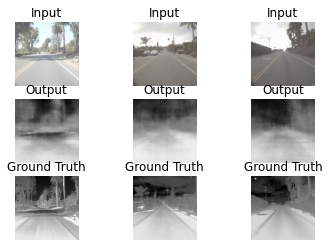

[Epoch 7/15]  [G loss: 0.022817] time: 0:14:39.183043


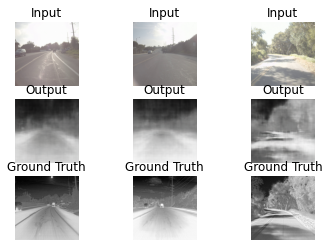

[Epoch 8/15]  [G loss: 0.028195] time: 0:16:28.595627


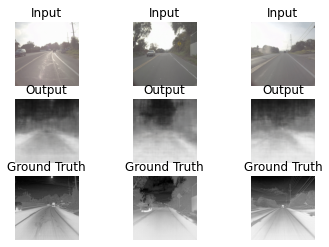

[Epoch 9/15]  [G loss: 0.016377] time: 0:18:16.987210


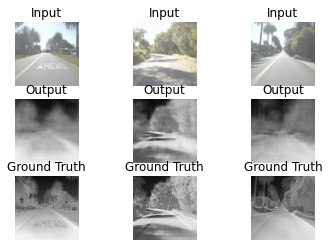

[Epoch 10/15]  [G loss: 0.012825] time: 0:20:04.530193


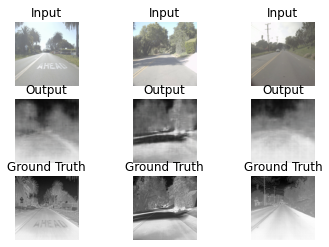

[Epoch 11/15]  [G loss: 0.013633] time: 0:21:51.921685


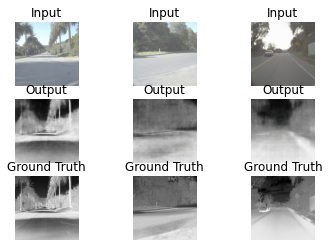

[Epoch 12/15]  [G loss: 0.010668] time: 0:23:39.572434


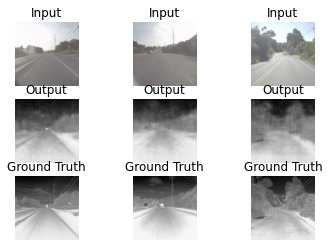

[Epoch 13/15]  [G loss: 0.011592] time: 0:25:28.328621


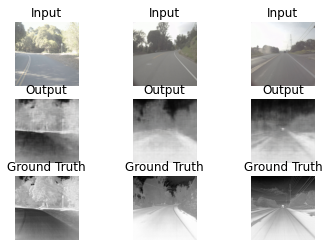

[Epoch 14/15]  [G loss: 0.010884] time: 0:27:16.678890


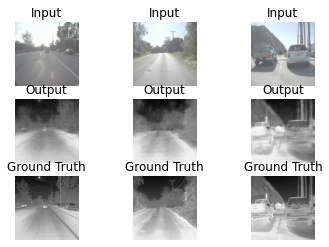

In [18]:
train(path1,path2,1,epochs=15, batch_size=4, show_interval=1)

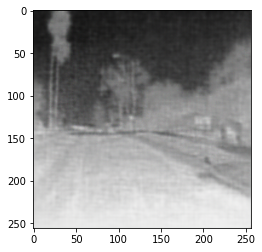

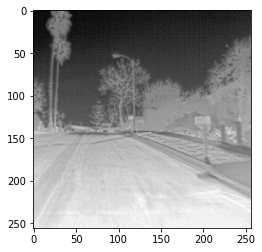

In [16]:
pa2=sorted(glob('../input/flirdata/RGB/RGB' + '/*.jpg'), key=lambda name: int(name[31:-4]))
pa1=sorted(glob('../input/flirdata/thermal_8_bit/thermal_8_bit' + '/*.jpeg'), key=lambda name: int(name[51:-5]))
inds=[]
con=0
for i in range(0,len(pa1)):
    a=int(pa2[con][31:-4])
    b=int(pa1[i][51:-5])
    if a==b:
        inds.append(i)
        con=con+1
pa1=np.array(pa1)[inds]

imgs_A, imgs_B = load_data(path1,path2,batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[1])               
plt.show()
plt.close()
plt.imshow(gen_imgs[2])               
plt.show()
plt.close()

In [ ]:
generator.save('gen.h5')
discriminator.save('disc.h5')
combined.save('combined.h5')
train_src_dataset = tf.data.Dataset.list_files('../input/deepnir-nir-rgb-nirscene1-dataset/nirscene_img_aug_100_oversample/train_A'+'/*.png',
                                               shuffle=False)
train_src_dataset = (
    train_src_dataset.map(load_image, num_parallel_calls=AUTOTUNE)
    .batch(batch_size, drop_remainder=True)
    .prefetch(AUTOTUNE)
)

if not(os.path.exists('images')):
    print("Creating folder...")
    os.makedirs('images') # Create folder to save generated images

def predict_and_save(input_ds, generator_model):
    i = 1
    for img in input_ds:
        prediction = generator(img, training=False)
        prediction = tf.cast((prediction * 127.5 + 127.5), tf.uint8)
        im = tf.squeeze(prediction, 0)
        im = im.numpy()
        im = Image.fromarray(im)
        im.save("images/" + str(i) + '.png')
        i += 1

predict_and_save(train_src_dataset, generator)

In [ ]:
epoch=[]
for i in range(0,5):
    epoch.append(i)
epoch_number=np.array(epoch)
plt.plot(epoch_number.T, gloss )
plt.plot(epoch_number.T, dloss)
plt.grid() #creating the grid
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("g and d losses ")
plt.legend(["G loss","D loss"])
plt.show()

In [ ]:
imgs_A, imgs_B = load_data('1a','1b',batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[1])               
plt.show()
plt.close()
plt.imshow(gen_imgs[2])               
plt.show()
plt.close()

In [ ]:
imgs_A, imgs_B = load_data('1a','1b',batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[1])               
plt.show()
plt.close()
plt.imshow(gen_imgs[2])               
plt.show()
plt.close()

In [ ]:
def pic(d1,d2,batch_size=1, is_val=False):

        
        path2=glob('../input/images/pix/p2')
        indices=np.random.randint(0,len(path2), size=batch_size)
        #print(indices)
        #b1 = np.array(path1)[indices]
        b2 = np.array(path2)[indices]
        #print(path1)
        #print(path2)
        #plt.imshow(b1[0])
        #plt.imshow(b2[0])
        img_res=(256,256)
        
        imgs_B = []

        for i in range(0,len(b2)):
            
            i2=b2[i]
            
            img2=imread(i2)
            
            img_B = img2

            # decreasing the resolution 
            
            img_B = transform.resize(img_B, img_res)  #Input image

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                
                img_B = np.fliplr(img_B)
  
                
                
            #print(img_A)
            #print(imgs_A)

            imgs_B.append(img_B)
            
            #print(imgs_A)

       
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return  imgs_B

In [ ]:
 imgs_B = pic('1a','1b',batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[0])               
plt.show()
plt.close()
plt.imshow(gen_imgs[1])               
plt.show()
plt.close()

In [ ]:
imgs_A, imgs_B = load_data('1a','1b',batch_size=1, is_val=True)
fake_A = generator.predict(imgs_B)
gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])

        # Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5

plt.imshow(gen_imgs[1])               
plt.show()
plt.close()
plt.imshow(gen_imgs[2])               
plt.show()
plt.close()